In [141]:
import duckdb
con = duckdb.connect("c:/Code/Local Code/deadlock_match_prediction/data/deadlock.db")
raw_con = duckdb.connect("c:/Code/Local Code/deadlock_match_prediction/match_player_raw.duckdb")

In [110]:
result = raw_con.execute("SELECT count(*) FROM staging_cleaned").fetchall()
print(result)

[(85901845,)]


In [143]:
con.close()
raw_con.close()

In [ ]:
match_df = con.execute("SELECT * FROM matches").fetchdf()
match_ids = match_df['match_id'].unique().tolist()

# Register match_df as a temporary DuckDB view
raw_con.register("match_df", match_df)

query = """
    SELECT 
        player_count,
        COUNT(*) AS match_count
    FROM (
        SELECT 
            s.match_id,
            COUNT(*) AS player_count
        FROM staging_cleaned s
        JOIN match_df m ON s.match_id = m.match_id
        GROUP BY s.match_id
    )
    GROUP BY player_count
    ORDER BY player_count
"""

query2 = """
    SELECT COUNT(DISTINCT match_id) from match_df;
"""
result = raw_con.execute(query).fetchdf()
print(result)
result2 = raw_con.execute(query2).fetchdf()
print(result2)

In [ ]:
    """Formats raw match_info to be combined with raw_match_players
    Combined data will live in deadlock.db.player_matches_history table
    """
raw_con.execute(f"""
        CREATE OR REPLACE TABLE high_quality_matches AS
        SELECT match_id, start_time, game_mode, match_mode, won
        FROM 'match_info_history'
        WHERE (average_badge_team0 + average_badge_team1) / 2 > 75
    """)
    result = raw_con.execute("Select count(*) from high_quality_matches").fetchone()[0]
    print(f"High quality matches count: {result}")

In [ ]:
raw_con.execute("CREATE OR REPLACE TABLE matches_for_training AS SELECT * FROM match_df")


In [111]:
result = raw_con.execute("select * from staging_cleaned limit 1").fetchdf()
print(result)

   match_id  account_id  player_slot  team  kills  deaths  assists  net_worth  \
0   1020422   130174860            9     1      9       8        9      25619   

   hero_id  last_hits  denies  ability_points  party  assigned_lane  \
0        4        143       1              21      1              6   

   player_level  abandon_match_time_s ability_stats  \
0            21                     0            {}   

                                     stats_type_stat    won  
0  [309.0158, 0.0, 2307.56, 22.0, 7.5, 0.0, 7.5, ...  False  


In [ ]:
result = con.execute("SELECT count(distinct account_id) FROM player_matches").fetchdf()
print(result)

In [112]:
result = raw_con.execute("""SELECT COUNT(*)
FROM staging_cleaned
WHERE match_id IN (
    SELECT DISTINCT match_id FROM matches_for_training
);""").fetchall()
print(result)

[(104172,)]


In [113]:
raw_con.execute("""SELECT COUNT(*) AS non_unique_match_ids
FROM (
    SELECT s.account_id
    FROM staging_cleaned s
    JOIN matches_for_training m ON s.match_id = m.match_id
    GROUP BY s.account_id
    HAVING COUNT(*) > 1
);""").fetchall()

[(6449,)]

*** Creates / replaces filtered_player_matches, completing with data from staging_cleared, where match_id matches matches_for_Training

This should create match history for all players in matches_for_training

In [114]:
raw_con.execute("""
    CREATE OR REPLACE TABLE filtered_player_matches AS
SELECT
    s.account_id,
    s.match_id,
    s.hero_id,
    s.team,
    s.kills,
    s.deaths,
    s.assists,
    s.denies,
    s.net_worth,
    s.won
FROM staging_cleaned s
WHERE s.account_id IN (
    SELECT DISTINCT account_id 
    FROM dup_player_matches
);
                """)

In [115]:
query1 = raw_con.execute("SELECT count(distinct match_id) from filtered_player_matches").fetchall()
query2 = raw_con.execute("SELECT count(*) from filtered_player_matches").fetchall()
print(query1)
print(query2)

[(3356348,)]
[(8316105,)]


Not sure the below is doing what I think it should. ignore output or review critically

In [116]:
raw_con.execute("""
    SELECT 
    player_count,
    COUNT(*) AS match_count
    FROM (
    SELECT 
        match_id,
        COUNT(account_id) AS player_count
    FROM filtered_player_matches
    GROUP BY match_id
)
GROUP BY player_count
ORDER BY player_count;                
                """).fetchall()

[(1, 1556710),
 (2, 753457),
 (3, 372722),
 (4, 213209),
 (5, 134999),
 (6, 93199),
 (7, 67647),
 (8, 50630),
 (9, 38669),
 (10, 29404),
 (11, 21764),
 (12, 23938)]

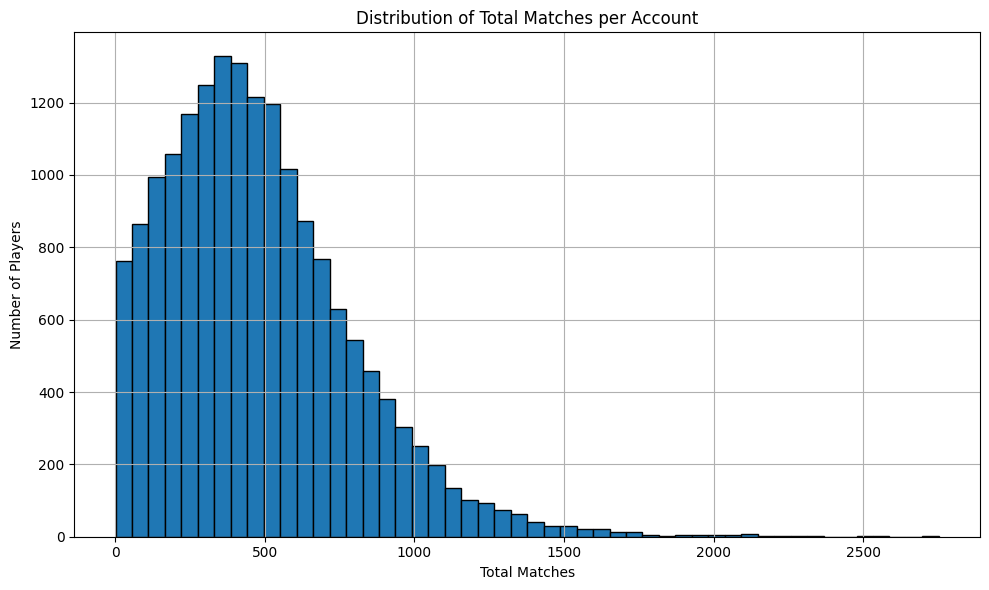

In [119]:
import duckdb
import matplotlib.pyplot as plt

df = raw_con.execute("""
    SELECT 
        account_id,
        COUNT(match_id) AS total_matches
    FROM filtered_player_matches
    GROUP BY account_id
""").fetchdf()

# Histogram for total matches
plt.figure(figsize=(10, 6))
plt.hist(df['total_matches'], bins=50, edgecolor='black')
plt.title('Distribution of Total Matches per Account')
plt.xlabel('Total Matches')
plt.ylabel('Number of Players')
plt.grid(True)
plt.tight_layout()
plt.show()

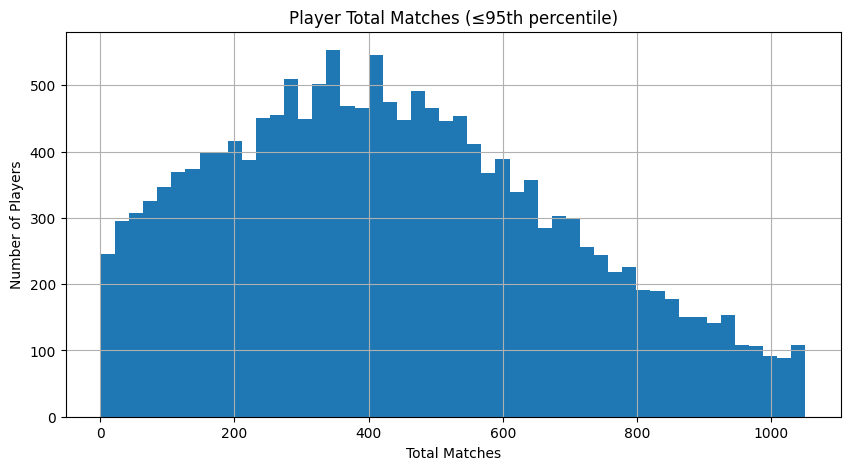

In [120]:
import numpy as np
# Fetch total match counts per player
df = raw_con.execute("""
    SELECT account_id, COUNT(*) AS total_matches
    FROM filtered_player_matches
    GROUP BY account_id
""").fetchdf()

# Calculate 95th percentile
p95 = np.percentile(df["total_matches"], 95)

# Plot
plt.figure(figsize=(10, 5))
plt.hist(df[df["total_matches"] <= p95]["total_matches"], bins=50)
plt.title("Player Total Matches (≤95th percentile)")
plt.xlabel("Total Matches")
plt.ylabel("Number of Players")
plt.grid(True)
plt.show()

In [ ]:
df = raw_con.execute("""SELECT COUNT(*) 
FROM staging_cleaned s
INNER JOIN matches_for_training m ON s.match_id = m.match_id;""").fetchdf()
print(f"{df.columns}\n\n {len(df)}")

Duplicate main.player_matches into raw_data.dup_player_matches

In [ ]:
df = con.execute("""
    select * from player_matches""").fetchdf()
print(f"{df.columns}\n\n {len(df)}")
raw_con.execute("""
    INSERT into dup_player_matches
    SELECT * FROM df
                """)

In [ ]:
result = raw_con.execute("SELECT count(*) from dup_player_matches").fetchdf()
print(result)

In [ ]:
con.execute("""
    UPDATE player_matches
    SET won = (
        SELECT CASE 
            WHEN player_matches.team = m.winning_team THEN 1 
            ELSE 0 
            END
        FROM matches m
        WHERE player_matches.match_id = m.match_id
);  """)

In [ ]:
oldest_fpm_match_start = raw_con.execute("""
    SELECT hqm.start_time
    FROM match_info_history hqm
    WHERE hqm.match_id = (
        SELECT MIN(match_id)
        FROM filtered_player_matches
    )
""").fetchone()

oldest_high_quality = raw_con.execute("""
    SELECT MIN(start_time) FROM high_quality_matches
""").fetchone()

print("Start time from lowest match_id:", oldest_fpm_match_start[0])
print("Oldest start time overall:", oldest_high_quality[0])

In [ ]:
result = raw_con.execute("SELECT count(*) from dup_player_matches limit 1").fetchdf()
print(result)

Count and display layout of multiple tables

In [121]:
result = raw_con.execute("SELECT COUNT(*) FROM matches_for_training").fetchdf()
print(f"matches_for_training: {result}")
result = raw_con.execute("SELECT * FROM matches_for_training LIMIT 1").fetchdf()
print(f"matches_for_training: {result}")

result = raw_con.execute("SELECT COUNT(*) FROM dup_player_matches").fetchdf()
print(f"\n\ndup_player_matches: {result}")
result = raw_con.execute("SELECT * FROM dup_player_matches LIMIT 1").fetchdf()
print(f"dup_player_matches: {result}")

result = raw_con.execute("SELECT COUNT(*) FROM filtered_player_matches").fetchdf()
print(f"\n\nfiltered_player_matches: {result}")
result = raw_con.execute("SELECT * FROM filtered_player_matches LIMIT 1").fetchdf()
print(f"filtered_player_matches: {result}")

result = raw_con.execute("SELECT COUNT(*) FROM high_quality_matches").fetchdf()
print(f"\n\nhigh_quality_matches: {result}")
result = raw_con.execute("SELECT * FROM high_quality_matches LIMIT 1").fetchdf()
print(f"high_quality_matches: {result}")

result = raw_con.execute("SELECT COUNT(*) FROM staging_cleaned").fetchdf()
print(f"\nstaging_cleaned: {result}")
result = raw_con.execute("SELECT * FROM staging_cleaned LIMIT 1").fetchdf()
print(f"staging_cleaned: {result}")

matches_for_training:    count_star()
0         13407
matches_for_training:    match_id          start_time game_mode match_mode  duration_s winning_team
0  35533788 2025-05-08 21:04:04    Normal   Unranked        2094        Team1


dup_player_matches:    count_star()
0        160884
dup_player_matches:    account_id  match_id  hero_id   team  kills  deaths  assists  denies  \
0  1699896029  35533788       19  Team0      6       9        7       1   

   net_worth    won  
0      34332  False  


filtered_player_matches:    count_star()
0       8316105
filtered_player_matches:    account_id  match_id  hero_id  team  kills  deaths  assists  denies  \
0   974492784  18795645       31     1     14       6       14      28   

   net_worth   won  
0      46259  True  


high_quality_matches:    count_star()
0        639719
high_quality_matches:    match_id                start_time  game_mode  match_mode
0  28724382 2024-11-22 16:40:20-05:00          1           1

staging_cleaned:    cou

# What distinct account_ids are in filtered_player_matches but not in dup_player_matches
Expectation should be zero.

In [125]:
unique_count = raw_con.execute("""
    SELECT COUNT(DISTINCT fpm.account_id) AS unique_count
    FROM filtered_player_matches fpm
    WHERE fpm.account_id NOT IN (
        SELECT account_id FROM dup_player_matches
    )
""").fetchone()

print("Unique account_ids not in dup_player_matches:", unique_count[0])

Unique account_ids not in dup_player_matches: 0


## How many matches of history for each player in filtered_player_matches
count occurance of each account_id in filtered_player_matches


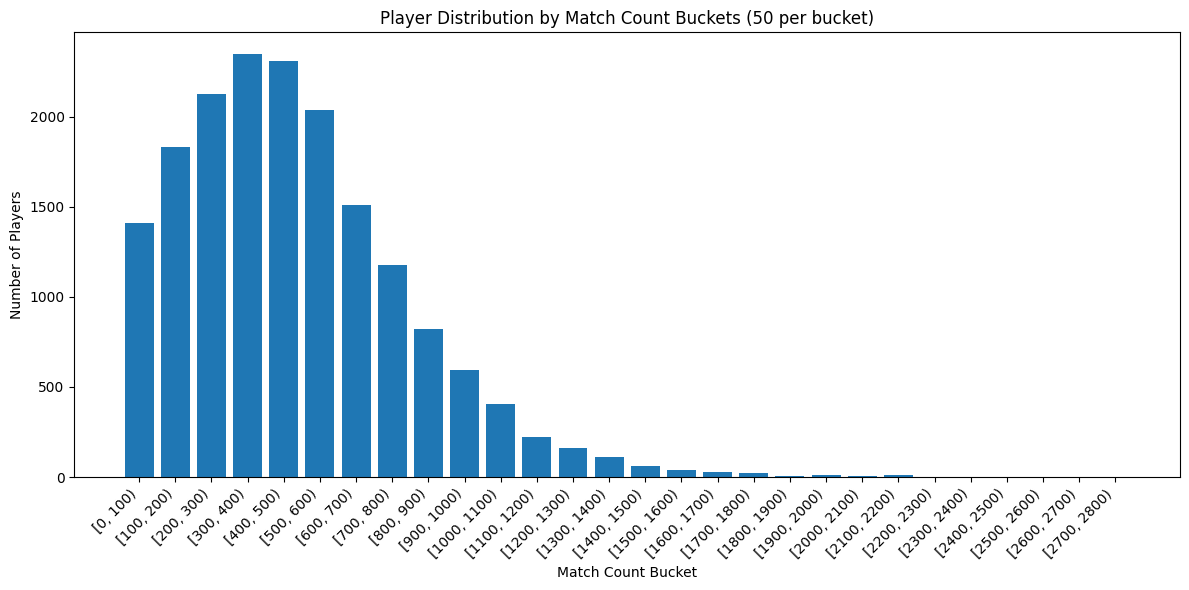

In [124]:
import matplotlib.pyplot as plt
import pandas as pd

# Fetch data
result = raw_con.execute("""
    SELECT account_id, COUNT(*) AS match_count
    FROM filtered_player_matches
    GROUP BY account_id
""").fetchdf()

# Bin match counts into buckets of 50
bins = range(0, result['match_count'].max() + 101, 100)
result['match_bucket'] = pd.cut(result['match_count'], bins=bins, right=False)

# Count players in each bucket
bucket_counts = result['match_bucket'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(bucket_counts.index.astype(str), bucket_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Match Count Bucket')
plt.ylabel('Number of Players')
plt.title('Player Distribution by Match Count Buckets (50 per bucket)')
plt.tight_layout()
plt.show()

# Combine data and insert into main.player_matches_history


In [128]:
df = raw_con.execute("""
    select * from filtered_player_matches""").fetchdf()
print(f"{df.columns}\n\n {len(df)}")
con.execute("""
    INSERT into player_matches_history
    SELECT * FROM df
                """)

Index(['account_id', 'match_id', 'hero_id', 'team', 'kills', 'deaths',
       'assists', 'denies', 'net_worth', 'won'],
      dtype='object')

 8316105


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [130]:
df = con.execute("""
    select count(*) from player_matches_history LIMIT 1""").fetchdf()
print(df)

   count_star()
0       8316105


In [142]:
df = con.execute("""
    select count(*) from player_matches_history WHERE account_id =1699896029""").fetchdf()
print(df)

   count_star()
0           117
